In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
def f(x):
    return 4*x**2 + 3*x + 2

In [3]:
f(1)

9

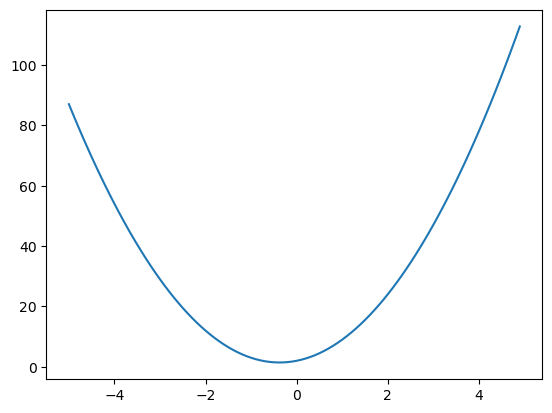

In [4]:
xs = np.arange(-5, 5, 0.1)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.0001
x = -3/8
(f(x+h)-f(x))/h

0.00039999999978945766

In [6]:
class Value:
    def __init__(self, data, _op='', _children=(), label=''):
        self._op = _op
        self.data = data
        self.label = label
        self._backward = lambda: None
        self._prev = set(_children)
        self.grad = 0.0

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        # out is the parent
        out = Value(self.data + other.data, '+', (self, other))
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, '*', (self, other))
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1-t**2)*out.grad

        out._backward = _backward
        return out

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')

a + b
#a.__add__(b)
c = Value(10.0, label='c')
e = a * b
e.label = 'e'
f = Value(-2.0, label='f')
d = e + c; d.label ='d'
L = d*f; L.label = 'L'
L

Value(data=-8.0)

In [7]:
# this part is going to be blindly typed,
# i have no familiarity with the graphviz library
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
        for child in v._prev:
            edges.add((child, v))
            build(child)
    build(root) # note how this function is defined above..
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)

    return dot



In [8]:
L.backward()

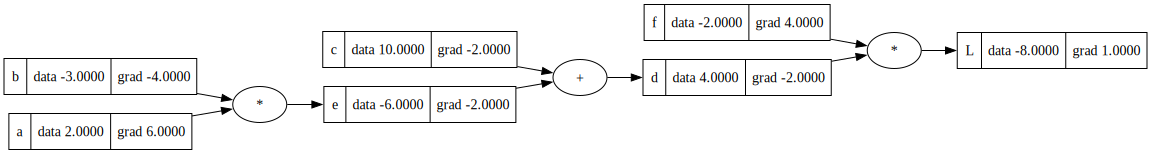

In [9]:
draw_dot(L)